In [ ]:
# https://github.com/PhilippeCodes/Advanced-Regression-Techniques/blob/master/house-prices/House-prices%20Gradient%20Boosting.ipynb

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import sqrt
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
#from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,9.958133,0.000000,0.000000,2.922424e+03,0.019789,8.295819e+02,891.377388,1.0,16.0,0.912022,2.0,63.873122,1.240458e+10,7.330045
1,13.589864,0.006419,922.528427,8.798615e+04,0.019789,7.448670e+05,6527.744480,1.0,32.0,0.905742,6.0,63.873122,1.240458e+10,37.569958
2,13.539800,0.151911,1001.244444,1.183198e+07,0.019789,3.649453e+06,15798.111111,1.0,49.0,0.888829,6.0,26.283558,1.240458e+10,37.569958
3,5.633917,0.151914,1001.266695,1.183060e+07,0.203466,3.661378e+06,16975.310562,1.0,65.0,0.901064,6.0,26.283558,1.240458e+10,37.396603
4,7.244292,0.146933,273.066667,1.176899e+07,0.203466,3.087269e+06,13670.911111,1.0,66.0,0.893493,6.0,23.183333,1.240458e+10,37.396603


In [3]:
df.totalcpu.unique()

array([ 2.,  6., 12.,  4., 24.])

In [4]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [5]:
#df.head(30)

In [6]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [7]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*1.5))/100
df_t['total_mem_util'] = (df['totalmemoryUtilization']*(df['totalmemory']*1.5))*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*1.5))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*(df_test['totalmemory']*1.5))*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.916194,136.389247,0.912022,16.0
1,5.748581,699.059575,0.905742,32.0
2,2.365520,699.059575,0.888829,49.0
3,2.365520,695.833975,0.901064,65.0
4,2.086500,695.833975,0.893493,66.0


In [8]:
#n = len(df_t)
#train_df = df_t[0:int(n*0.8)]
#test_df = df_t[int(n*0.8):]
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
x_train = preprocessing.normalize(x_train, norm='max')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
x_test = preprocessing.normalize(x_test, norm='max')

In [9]:
#x_train = train_df[[col for col in train_df.columns if col != 'responsetime']]
#y_train = train_df['responsetime']

#x_test = test_df[[col for col in test_df.columns if col != 'responsetime']]
#y_test = test_df['responsetime']
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

linear reg score on our train data: 58.822
linear reg score on our test data: 238.304
R² : 0.5017807664973
Best Score:  0.7739805718593172
Best Params:  {'fit_intercept': False}


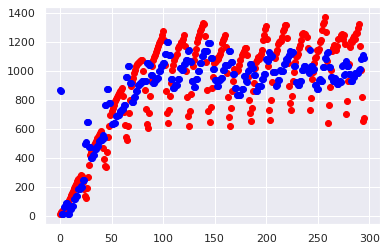

In [10]:
parameters = {'fit_intercept':[True,False]}
linear = GridSearchCV(LinearRegression(),
                      parameters, 
                      cv=7,
                      scoring='r2',
                      n_jobs=-1)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
y_te_pred = linear.predict(x_test)

print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', linear.best_score_)
print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Polynomial Regression

linear reg score on our train data: 51.961
linear reg score on our test data: 273.332
R² : 0.3445504504336451
Best Score:  0.7641152640291395
Best Params:  {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 3}


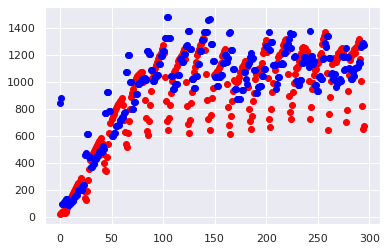

In [11]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [3,4 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [True, False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=7,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
y_te_pred = polynomial.predict(x_test)

print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Ridge Regression

RMSLE on our train data: 58.822
RMSLE on our test data: 238.304
R² : 0.5017807664973002
Best Score:  0.7739805718593136
Best Params:  {'alpha': 1e-20, 'max_iter': 1000}


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.23523e-19): result may not be accurate.
  overwrite_a=True).T


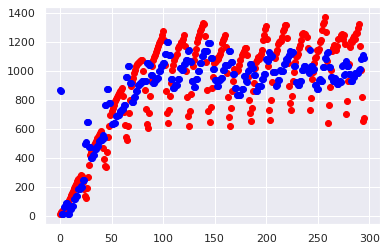

In [12]:
alphas = np.logspace(-20,10,num=20)
pram_grid = {'max_iter': np.arange(1000,20000,1000),
             'alpha': alphas}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=pram_grid,
                         cv=7, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
y_te_pred = ridge_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Lasso Regression

In [ ]:
pram_grid = {'max_iter': np.arange(1000,20000,1000),
             'alpha': alphas}
lasso_cv = GridSearchCV(Lasso(),
                       param_grid=pram_grid,
                         cv=7, 
                        scoring='r2',
                         n_jobs=-1)

lasso_cv.fit(x_train, y_train)

y_tr_pred = lasso_cv.predict(x_train)
y_te_pred = lasso_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', lasso_cv.best_score_)
print('Best Params: ', lasso_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer=init, activation='relu'))
    model.add(Dense(4, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, verbose=0)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [5, 10, 30]
batches = [100, 150]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                   cv=5, 
                         scoring='r2',
                         n_jobs=-1,
                   verbose=10)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Grid search and Deeplearning models in python with keras

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the learning rate and momentum
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the weight initialization
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='uniform', activation=activation))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the dropout rate
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the number of neurons
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
neurons = [5, 6, 10]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Huber Regressor

In [ ]:
epsilon = np.arange(1, 1.5, 0.05)


huber_cv = GridSearchCV(HuberRegressor(),
                       {'epsilon': epsilon,
                        'alpha': alphas},
                         cv=7, 
                         scoring='r2',
                         n_jobs=-1)

huber_cv.fit(x_train, y_train)

y_tr_pred = huber_cv.predict(x_train)
y_te_pred = huber_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', huber_cv.best_score_)
print('Best Params: ', huber_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Random Forrest Regressor

In [ ]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': [10, 15, 20],
                 'n_estimators': [100, 150, 200],
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=7, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
y_te_pred = rf_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

In [ ]:
finalrf_cv = RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150)
finalrf_cv.fit(x_train, y_train)
y_tr_pred = finalrf_cv.predict(x_train)
y_te_pred = finalrf_cv.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# ElasticNet

In [ ]:
# find optimal alpha with grid search
alpha = np.logspace(-20,10,num=20)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(ElasticNet(), 
                    param_grid=param_grid,
                    cv=7,
                    scoring='r2', 
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

y_tr_pred = grid.predict(x_train)
y_te_pred = grid.predict(x_test)
from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Gradient Boosting Regressor

In [ ]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                 'learning_rate': [0.02],
                 'min_samples_split': [10, 15, 20],
                 'min_samples_leaf': [10, 15, 20],
                 'max_depth': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000],
                 'loss': ['ls', 'lad', 'huber', 'quantile'],
                 'max_features': ['sqrt']
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
y_te_pred = GBoost_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

In [ ]:
plt.scatter(range(0,len(y_train)),y_train, color='red')
plt.scatter(range(0,len(y_tr_pred)),y_tr_pred, color='blue')

In [ ]:
gboostFinal = GradientBoostingRegressor(learning_rate=0.02, 
                                        loss= 'lad', 
                                        max_depth=5, 
                                        max_features= 'sqrt', 
                                        min_samples_leaf= 20, 
                                        min_samples_split= 10, 
                                        n_estimators= 1000)
gboostFinal.fit(x_train, y_train)

y_tr_pred = gboostFinal.predict(x_train)
y_te_pred = gboostFinal.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')